In [1]:
using LinearAlgebra, Plots
using Dates
import Dates: DateTime
using Test
using Random
import Convex as cvx 
import ECOS 
import SCS
import Mosek
using ProgressMeter
using JuMP
using Statistics
using MosekTools
using Distributions
using Noise
using CSV
using DataFrames
using LaTeXStrings

In [2]:
function swapcol!(x,i,j)
     for k in axes(x,1) # edited according to next answer
       idata = x[k,i]
       x[k,i] = x[k,j]
       x[k,j] = idata
     end
end

# Initialize a normalized gussian type bell function to convert daily to hourly inflows and releases
function bell(qtd,k,a)
    qt = zeros(24)
    # a=50
    x = zeros(24)
    qadd = zeros(24)
    
    for i=1:24
        qadd[i] = (a)*2.71828^(-0.06*(i-k)^2)
    end
    
    while(qtd-mean(qadd)<0)
        a=a-1
        for i=1:24
            qadd[i] = (a)*2.71828^(-0.06*(i-k)^2)
        end
    end 
    
    for i=1:24
        qt[i] = (qtd)+qadd[i]
    end
    
    g = (mean(qadd))

    for i=1:24
        qt[i]=qt[i]-g
    end
    
    qt
end

# Function to convert volume to level in meters 
function level(s)
    p = sqrt((3.083e+05*3.083e+05)-(4*7.738e+05*(8601 - s)))
    return ((((-3.083e+05+p)/(2*7.738e+05))+h_ref)*3.28084)
end

# Function to covert level (meters) above reference level to volume
function vol(h)
    return (7.738e+05*h*h)+ (3.083e+05*h) + 8601
end;

In [3]:
# Daily Demand starting at 1st jan
w_mean_dum = [0.2279506184,0.2279506184,0.165653555,0.1642377126,0.1642377126,0.210252589,0.210252589,0.1465396832,0.1465396832,0.226534776,0.2229951701,0.2088367466,0.2088367466,0.2088367466,0.1628218703,0.1628218703,0.1628218703,0.1628218703,0.1628218703,0.1628218703,0.1019406492,0.1019406492,0.1019406492,0.1019406492,0.1628218703,0.1005248069,0.08636638335,0.1274258115,0.1486634468,0.1486634468,0.1486634468,0.1486634468,0.1486634468,0.1486634468,0.1486634468,0.1486634468,0.1486634468,0.2109605102,0.2109605102,0.2520199383,0.2760892583,0.2675942042,0.2888318394,0.2888318394,0.2888318394,0.335554637,0.3978517004,0.4474061826,0.4551933155,0.3928962521,0.368119011,0.3617477204,0.4601487638,0.4566091579,0.3914804098,0.396435858,0.4587329214,0.5005002707,0.5146586942,0.5373121718,0.6562429292,0.7256192044,0.6831439339,0.7206637562,0.8282677748,0.8558767006,0.8558767006,0.9110945522,0.9089707887,0.8041984548,0.8041984548,0.6980102786,0.6357132152,0.622970634,0.622970634,0.5748319941,0.4962527437,0.5181983001,0.5238616695,0.5146586942,0.4665200543,0.4636883696,0.4013913062,0.3872328827,0.4070546756,0.3270595829,0.323519977,0.2704258889,0.2704258889,0.2081288255,0.1854753479,0.1231782845,0.1444159197,0.1231782845,0.1231782845,0.09132183158,0.09132183158,0.09698520098,0.08990598923,0.0736238022,0.03822774345,0.03822774345,0.03822774345,0.03822774345,0.03822774345,0.03822774345,0.03822774345,0.03822774345,0.03822774345,0.03822774345,0.03822774345,0.03822774345,0.03822774345,0.03822774345,0.0424752705,0.03822774345,0.03822774345,0.03822774345,0.03822774345,0.03822774345,0.03822774345,0.03822774345,0.03822774345,0.03822774345,0.03822774345,0.03822774345,0.03822774345,0.03822774345,0.03822774345,0.03822774345,0.03822774345,0.03822774345,0.03822774345,0.03822774345,0.03822774345,0.03822774345,0.0424752705,0.0424752705,0.0424752705,0.0424752705,0.0424752705,0.0424752705,0.0424752705,0.0424752705,0.0424752705,0.0424752705,0.0424752705,0.0424752705,0.0424752705,0.0424752705,0.0424752705,0.0424752705,0.0424752705,0.0424752705,0.0424752705,0.03822774345,0.03822774345,0.03822774345,0.03822774345,0.03822774345,0.03822774345,0.03822774345,0.03822774345,0.03822774345,0.03822774345,0.03822774345,0.03822774345,0.03822774345,0.03822774345,0.03822774345,0.03822774345,0.03822774345,0.03822774345,0.03822774345,0.03822774345,0.03822774345,0.03822774345,0.03822774345,0.03822774345,0.03822774345,0.03822774345,0.03822774345,0.0396435858,0.0396435858,0.0396435858,0.0396435858,0.0396435858,0.0396435858,0.0396435858,0.0396435858,0.0396435858,0.0396435858,0.0396435858,0.0396435858,0.0396435858,0.0396435858,0.0396435858,0.0396435858,0.0396435858,0.0396435858,0.04105942815,0.04105942815,0.04105942815,0.04105942815,0.04105942815,0.04105942815,0.04105942815,0.04105942815,0.04105942815,0.04105942815,0.04105942815,0.04105942815,0.04105942815,0.04105942815,0.04105942815,0.04105942815,0.04105942815,0.04105942815,0.04105942815,0.04105942815,0.04105942815,0.04105942815,0.04105942815,0.04105942815,0.04105942815,0.04105942815,0.04105942815,0.04105942815,0.04105942815,0.04105942815,0.04105942815,0.04105942815,0.04105942815,0.04105942815,0.04105942815,0.04105942815,0.04105942815,0.04105942815,0.04105942815,0.04105942815,0.04105942815,0.04105942815,0.04105942815,0.04105942815,0.04105942815,0.04105942815,0.04105942815,0.04105942815,0.04105942815,0.04105942815,0.04105942815,0.04105942815,0.04105942815,0.04105942815,0.04105942815,0.04105942815,0.04105942815,0.04105942815,0.04105942815,0.04105942815,0.04105942815,0.04105942815,0.04105942815,0.04105942815,0.04105942815,0.04105942815,0.04105942815,0.04105942815,0.04105942815,0.04105942815,0.04105942815,0.04105942815,0.04105942815,0.04105942815,0.04105942815,0.04105942815,0.04105942815,0.04105942815,0.04105942815,0.04105942815,0.04105942815,0.04105942815,0.04105942815,0.04105942815,0.04601487638,0.04601487638,0.04601487638,0.04601487638,0.04601487638,0.04601487638,0.04601487638,0.04601487638,0.04601487638,0.04601487638,0.09273767392,0.1005248069,0.1040644127,0.1649456338,0.2038812984,0.2109605102,0.2251189337,0.2251189337,0.2251189337,0.2251189337,0.2251189337,0.2251189337,0.2251189337,0.2251189337,0.2251189337,0.2251189337,0.2251189337,0.2251189337,0.2251189337,0.2732575736,0.2874159971,0.2874159971,0.4466982614,0.4636883696,0.4714755026,0.4743071873,0.5153666154,0.5635052553,0.5847428906,0.5925300235,0.5366042507,0.6484557963,0.7447330761,0.8551687794,0.8700351241,0.8990598923,0.9025994981,0.9719757733,0.9762233003,1.015158965,1.117099614,1.127718432,1.079579792,1.12063922,1.076040186,1.082411477,1.059050078,0.9309163451,1.047723339,1.022238177,0.9443668475,0.9210054487,0.9394113992,0.9132183158,0.9132183158,0.8509212524,0.833223223,0.7560598149,0.7150003868,0.5953617082,0.5918221023,0.5295250389,0.448822025,0.4955448225,0.4566091579,0.4566091579,0.4608566849,0.4608566849,0.3475892969,0.339802164,0.339802164]


# Daily Demand starting from 1st October
w_mean_day = zeros(365)
for i=274:365
    w_mean_day[i-273] = w_mean_dum[i]
end
for i=1:273
    w_mean_day[i+92] = w_mean_dum[i]
end

# Change daily to hourly demand
w_mean_hr = zeros(8760)
for i=0:364
    for j=1:24
        w_mean_hr[(24*i)+j]=w_mean_day[i+1]
    end
end

In [4]:
# Uncomment to view plot of average hourly agricultural demand
# plot(w_mean_hr, label="Hourly Water Demand", lw=2, dpi=500, size=(700,550),tickfontsize=12,labelfontsize=20,title="Historical Average Hourly Demand",titlefontsize=20)
# xlabel!("Time (Hours)")
# ylabel!("Flow rate (m\$^3\$/s)")

In [5]:
#Zero Level set at 1152.7 feet
h_ref = 351.34296;

# Lake Flood Level 1169 feet
h_max = 356.3112-h_ref

#lake Dry Level 1154 feet
h_min = 0.39

# Max Volume
global s_max = vol(h_max)

# Min Volume
global s_min = vol(h_min);


In [6]:
# observed flows from 2nd oct 1991 to 30th sep 1992
dr = DateTime(1991,10,2):Dates.Hour(1):DateTime(1992,09,30,23)

q_d1992 = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19.8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16.5,0,37.2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15.79,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17.4,0,0,0,19.1,0,0,0,0,0,0,0,20.32,46.89,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,53.09,0,0,0,0,69.3,74.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

# Change from daily to hourly
q_h1992 = []
for i=1:365
    append!(q_h1992,bell(q_d1992[i],12,50))
end

In [7]:
# Preping 1992 hydrological model derived flows to compare with Hydrologic-MPC

q_d92_sim = [1.52,1.48,1.43,1.42,1.42,1.40,1.39,1.38,1.37,1.37,1.36,1.38,1.39,1.37,1.38,1.38,1.40,1.37,1.33,1.35,1.37,1.34,1.34,1.35,1.31,1.32,1.34,1.31,1.31,1.33,1.29,1.30,1.29,1.30,1.31,1.31,1.29,1.29,1.04,1.45,1.35,1.06,1.18,1.53,1.10,1.18,1.22,1.24,1.24,1.24,1.23,1.24,1.22,1.21,1.21,1.21,1.21,1.19,1.19,1.20,1.20,1.17,1.17,1.18,1.18,1.18,1.18,1.15,1.15,1.14,1.15,1.14,1.12,1.12,1.13,1.13,1.12,1.11,1.10,1.10,1.10,1.10,1.09,1.08,1.07,1.07,1.06,1.06,1.05,1.05,1.04,1.04,1.04,1.04,1.03,1.03,0.97,0.97,0.98,0.98,0.99,0.98,0.98,0.98,0.98,0.98,0.96,0.96,0.95,0.95,0.95,0.93,0.93,0.93,0.92,0.92,0.92,0.92,0.92,0.92,5.82,3.24,2.13,1.57,1.29,0.91,0.98,1.00,1.00,0.97,0.95,0.93,0.90,0.89,2.34,1.72,1.37,0.93,1.00,0.99,0.98,0.95,0.94,0.91,0.89,0.86,0.85,0.84,0.82,0.82,0.82,0.81,0.80,0.79,0.78,0.77,0.77,0.77,0.75,0.76,0.76,0.75,0.74,0.73,0.72,0.71,0.71,0.70,0.69,0.68,0.68,0.67,0.73,0.76,0.75,0.75,1.42,1.01,0.99,0.97,0.93,0.86,0.83,0.80,0.76,0.72,0.71,0.74,0.74,0.75,0.73,0.70,0.68,0.67,0.65,0.64,0.62,0.62,0.61,0.60,0.59,0.58,1.29,0.92,0.92,0.90,0.82,0.77,0.71,0.68,0.64,0.63,0.61,0.60,0.57,0.55,0.55,0.53,0.52,0.51,0.50,0.49,0.48,0.47,0.46,0.46,0.45,0.45,0.44,0.44,0.43,0.42,0.42,0.41,0.41,0.40,0.40,0.40,0.39,0.39,0.39,0.38,0.38,0.37,0.37,0.36,0.36,0.35,0.36,0.35,0.34,0.34,0.34,0.33,0.33,0.33,0.32,0.32,0.31,0.31,0.31,0.30,0.30,0.29,0.29,0.29,0.29,0.28,0.28,0.28,0.27,0.27,0.27,0.26,0.26,0.26,0.25,0.26,0.27,0.28,0.28,0.28,4.19,2.60,1.50,2.12,1.68,1.32,0.84,0.81,0.74,0.64,0.56,0.49,0.44,0.39,0.40,0.39,0.39,0.38,0.37,0.36,0.35,0.34,0.34,0.33,0.32,0.32,0.33,0.38,0.42,0.46,52.10,30.00,6.95,3.48,1.97,1.01,0.99,1.88,1.55,1.42,0.98,0.93,0.90,0.84,0.78,0.73,0.70,0.76,0.79,0.80,0.79,0.78,0.76,0.75,0.74,0.94,1.90,1.42,0.97,1.61,3.75,64.60,49.90,12.80,5.55,3.13,2.11,1.51,1.37,1.33,1.28,0.90,1.09,1.14,1.10,1.10,1.11,1.09,1.12,1.12,1.09,1.08,1.11,1.09]

q_h92_sim=zeros(8760)
for i=0:364
    if q_d92_sim[i+1]==0
        a =zeros(24)
        q_h92_sim[(24*i)+1:(24*i)+24]= a
    else
        q_h92_sim[(24*i)+1:(24*i)+24]= bell(q_d92_sim[i+1],12,50)
    end
end
nd = ones(365)
for i=1:274
    nd[i]=0
end
n=ones(8760)
for i=1:6500
    n[i]=0
end
q_d92_sim = q_d92_sim[2:366].*nd
b = 2.53
c = 2.6;
M = 50
for i=1:6
    append!(q_d92_sim,0)
end

# plot([q_d92_sim[270:end],q_d1992[270:end]], label=["Simulated Lake Inflows during 1992" "Actual Historical Flows in 1992"], lw=2, dpi=500, size=(900,750),tickfontsize=12,labelfontsize=20,title="1991-1992 Simulated Hourly Lake Inflows",titlefontsize=20)
# xlabel!("Date")
# ylabel!("Flow rate (cubic meters per second)")


In [8]:
q_h1992_2 = []
for i=1:365
    append!(q_h1992_2,bell(q_d1992[i],rand(1:24),rand(50:100)))
end
# plot(dr[8240:8300],q_h1992_2[8240:8300], label="Hourly Lake Inflows during 1991-1992 water year", lw=2, dpi=500, size=(900,750),tickfontsize=12,labelfontsize=20,title="1991-1992 Hourly Lake Inflows",titlefontsize=20)
# # plot!(dr,q_h92_sim, label="Simulated Hourly Lake Inflows during 1991-1992 water year", lw=2)
# xlabel!("Date")
# ylabel!("Flow rate (cubic meters per second)")

In [ ]:
# AS-MPC Simulation 

# Height Threshold for Adaptive scenario generation (1160ft)
h_th = 353.7204-h_ref

# initial height at 1 jul 2010 (1155 ft)
h_ic = 355.7016-h_ref

# # initial height at for 2017-18
# h_ic = 354.26904-h_ref

# # # initial height at for 2019-20
# h_ic = 354.08616-h_ref

# # # initial height at for 1991-92 (1161)
# h_ic = 353.8728-h_ref

# # initial State at 31 august 1992 (1167 ft)
# h_ic = 355.7016-h_ref

# Set Horizon in Hours and initial condition
S = 168
s_ic =vol(h_ic)

# Variable to store results from MPC simulation
global ur0 = []
global ϵ_m0 = []
global xr0 = [s_ic]
global xr_real0 = [s_ic];
global h_real0 = [h_ic]

# error
error = 0

# Set number of scenarios
M = 200

w = copy(w_mean_hr[8040:end])

# q = copy(q_h2018)
# q = copy(q_h2015)
# q = copy(q_h)

# # For Hydrologic-MPC for 1992 Scenario
# q = copy(q_d92_sim)
h_dum = h_ic
h_dum2 = h_ic
day = 334
for i = 8040:8758
    cost_vec = zeros(M)
    control = zeros(M)
    dist = zeros(M)
    x_save = zeros(M)
    x_check = 0
    ϵ = zeros(M)
    di = 0
    if mod(i,24)==0
        day = day+1
    end
    

    u_max = (sqrt(h_real0[end]/b))*c+ 7.87
    u_min = 0

    if s_ic>s_max
        u_max = ((sqrt(h_real0[end]/b))*c) + 7.87
        u_min = ((sqrt(h_real0[end]/b))*c) + 7.87
    end
    
    if i>8650
        u_max = w_mean_hr[i]
        u_min = 0
    end
    
    if error>0
        
        for m=1:M
            if mod(i,24)==0
                q = []
                for j=day:day+6
                    append!(q,bell(q_d92_sim[j],12,50))
                end
                # conv = max(0,((h_dum-h_dum2)*error*error))
                conv = error*error
                q = max.(0,add_gauss(q, min(200,conv)))
                # q.+=min(100,error)
            end
            if mod(i,24)>0 
                q = []
                for j=day:day+6
                    append!(q,bell(q_d92_sim[j],12,50))
                end
                for k=1:mod(i,24)
                    popfirst!(q)
                    append!(q,0)
                end
                # conv = max(0,((h_dum-h_dum2)*error*error))
                conv = error*error
                q = max.(0,add_gauss(q, min(200,conv)))
                # q.+=min(100,error)
            end


            let 

                # create linear system
                A = 1
                B = 3600

                # time steps 

                if i>=8760-S
                    N = 8760-i
                else
                    N = S
                end

                # create cvx variables
                X = cvx.Variable(1, N)
                U = cvx.Variable(1, N - 1)
                b = cvx.Variable()

                # create cost 
                global cost = 0 
                for k = 1:(N-1)
                    cost += 0.001*cvx.square(cvx.norm(U[k]-w[k],2))
                end
                cost += cvx.square(cvx.norm(b/3600))
                # initialize cvx problem 
                prob = cvx.minimize(cost)

                # initial condition constraint 
                prob.constraints += X[1] == s_ic

                for k = 1:(N-1)
                    # dynamics constraints 
                    prob.constraints += (X[k+1] == A*X[k] - B*U[k] + B*q[k]) 
                end


                for k = 1:(N-1)
                    prob.constraints += U[k] <= u_max
                    prob.constraints += U[k] >= u_min
                end

                # prob.constraints += b>=0
                # prob.constraints += d>=0
                for k = 1:N
                    prob.constraints += X[k] <= s_max + b
                    prob.constraints += X[k] >= s_min 
                end

                cvx.solve!(prob, Mosek.Optimizer; silent_solver = true)
                global X = X.value
                global U = U.value
                cost_vec[m] = prob.optval

                # ϵ[m] = b.value
            end
            if i<8758
                um1 = vec(U);
                control[m]=um1[1]
            else
                control[m]= U
            end
            dist[m] = q[1]
            x_save[m] = maximum(vec(X)[2])
        end

        index = findmax(cost_vec)[2]
        append!(ur0,control[index])
        di = dist[index]
        x_check = x_save[index]
    else
        if mod(i,24)==0
            q = []
            for j=day:day+6
                append!(q,bell(q_d92_sim[j],12,50))
            end
        end
        if mod(i,24)>0 
            q = []
            for j=day:day+6
                append!(q,bell(q_d92_sim[j],12,50))
            end
            for k=1:mod(i,24)
                popfirst!(q)
                append!(q,0)
            end
        end
        let 

            # create linear system
            A = 1
            B = 3600

            # time steps 

            if i>=8760-S
                N = 8760-i
            else
                N = S
            end

            # create cvx variables
            X = cvx.Variable(1, N)
            U = cvx.Variable(1, N - 1)
            b = cvx.Variable()
         
            # create cost 
            global cost = 0 
            for k = 1:(N-1)
                cost += 0.001*cvx.square(cvx.norm(U[k]-w[k],2))
            end
            cost += cvx.square(cvx.norm(b/3600))

            # initialize cvx problem 
            prob = cvx.minimize(cost)

            # initial condition constraint 
            prob.constraints += X[1] == s_ic

            for k = 1:(N-1)
                # dynamics constraints 
                prob.constraints += (X[k+1] == A*X[k] - B*U[k] + B*q[k]) 
            end


            for k = 1:(N-1)
                prob.constraints += U[k] <= u_max
                prob.constraints += U[k] >= u_min
            end

            # prob.constraints += b>=0
            # prob.constraints += d>=0
            for k = 1:N
                prob.constraints += X[k] <= s_max + b
                prob.constraints += X[k] >= s_min 
            end

            cvx.solve!(prob, Mosek.Optimizer; silent_solver = true)
            global X = X.value
            global U = U.value
            # cost_vec[m] = prob.optval
            # append!(ϵ_m2,b.value)
        end

        if i<8758
            x_dum = vec(X)
            u_dum = vec(U);

            append!(xr0,x_dum[2])
            append!(ur0,u_dum[1])
        else
            x_dum = vec(X)
            append!(xr0,x_dum)
            append!(ur0,U)
        end
        di = q[1]
        x_check = maximum(vec(X)[2])
    end

    popfirst!(w)
    

    # Apply actual disturbance with control input generated using simulated disturbance/inflow
    # # for 2018 Scenario
    # dum = s_ic-3600*ur[end]+3600*q_h2018[i+1]
    # # for 2015 Scenario
    # dum = s_ic-3600*ur[end]+3600*q_h2015[i+1]
    # # for 2020 Scenario
    # dum = s_ic-3600*ur[end]+3600*q_h2020[i+1]
    # for 1992 Scenario
    dum = s_ic-3600*ur0[end]+3600*q_h1992_2[i+1]
    dum2 = s_ic-3600*ur0[end]+3600*di
    # append!(xr,dum2)
    h_dum = (level(dum)/3.28084)-h_ref
    # h_dum2 = (level(dum2)/3.28084)-h_ref
    h_dum2 = (level(x_check)/3.28084)-h_ref
    error = (dum-x_check)/3600
    # println(error)
    append!(ϵ_m0,max(0,dum-s_max))
    # appending it to actual trajectory of state (volume) for ploting later
    append!(xr_real0,dum)
    append!(h_real0,h_dum)
    # Changing initial condition to actual state after MPC iteration
    s_ic = xr_real0[end]
end

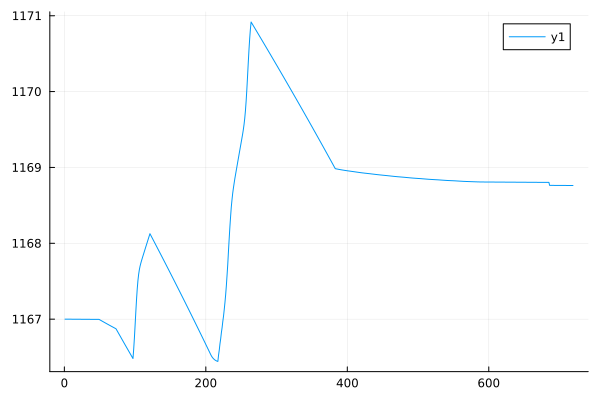

In [379]:
plot(level.(xr_real0))

In [ ]:
# Deterministic MPC

# initial State at 31 august 1992 (1167 ft)
h_ic = 355.7016-h_ref

# Set Horizon in Hours and initial condition
S = 168
s_ic =vol(h_ic)

# Variable to store results from MPC simulation
global ur2 = []
global ϵ_m2 = []
global xr2 = []
global xr_real2 = [s_ic];
global h_real2 = [h_ic]

w = copy(w_mean_hr[8040:end])

day = 334
for i = 8040:8758

    if mod(i,24)==0
        day = day+1
        global q = []
        for j=day:day+6
            append!(q,bell(q_d92_sim[j],12,50))
        end
    end
    
    

    
    u_max = ((sqrt(h_real2[end]/b))*c) + 7.87
    u_min = 0

    if s_ic>s_max
        u_max = ((sqrt(h_real2[end]/b))*c) + 7.87
        u_min = ((sqrt(h_real2[end]/b))*c) + 7.87
    end
    
    if i>8650
        u_max = w_mean_hr[i]
        u_min = 0
    end

    let 

        # create linear system
        A = 1
        B = 3600

        # time steps 

        if i>=8760-S
            N = 8760-i
        else
            N = S
        end

        # create cvx variables
        X = cvx.Variable(1, N)
        U = cvx.Variable(1, N - 1)
        δ = cvx.Variable()
        # create cost 
        global cost = 0 
        for k = 1:(N-1)
            cost += 0.01*cvx.square(cvx.norm(U[k]-w[k],2))
        end
        cost += cvx.square(δ/3600)

        # initialize cvx problem 
        prob = cvx.minimize(cost)

        # initial condition constraint 
        prob.constraints += X[1] == s_ic

        for k = 1:(N-1)
            # dynamics constraints 
            prob.constraints += (X[k+1] == A*X[k] - B*U[k] + B*q[k]) 
        end

        for k = 1:(N-1)
            prob.constraints += U[k] <= u_max
            prob.constraints += U[k] >= u_min
        end

        for k = 1:N
            prob.constraints += X[k] <= s_max + δ
            prob.constraints += X[k] >= s_min 
        end

        cvx.solve!(prob, Mosek.Optimizer; silent_solver = true)
        global X = X.value
        global U = U.value
        append!(ϵ_m2,δ.value)

    end

    if i<8758
        x_dum = vec(X)
        u_dum = vec(U);

        append!(xr2,x_dum[2])
        append!(ur2,u_dum[1])

        popfirst!(q)
        append!(q,0)
        popfirst!(w)
    else
        x_dum = vec(X)
        append!(xr2,x_dum)
        append!(ur2,U)
    end

    # Apply actual disturbance with control input generated using simulated disturbance/inflow
    dum = s_ic-3600*ur2[end]+3600*q_h1992_2[i+1]
    h_dum = (level(dum)/3.28084)-h_ref
    
    
    # appending it to actual trajectory of state (volume) for ploting later
    append!(xr_real2,dum)
    append!(h_real2,h_dum)
    # Changing initial condition to actual state after MPC iteration
    s_ic = xr_real2[end]
end

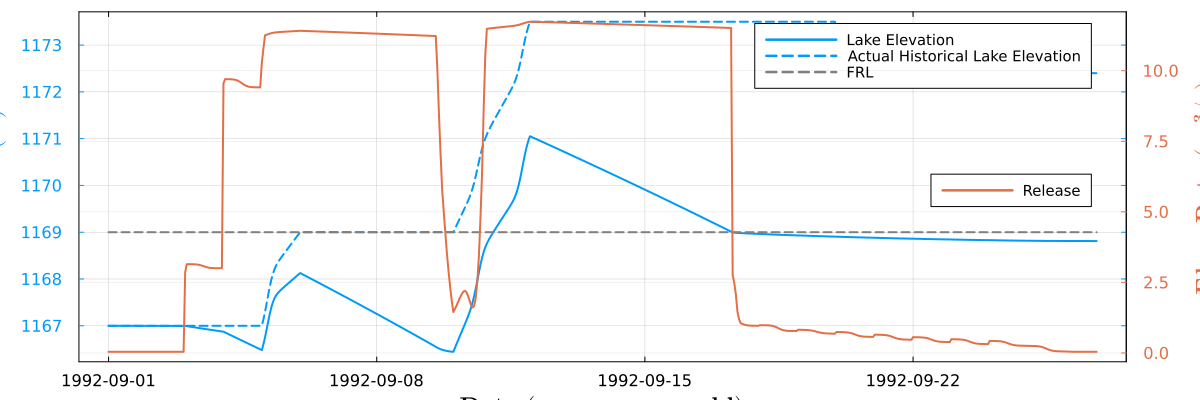

In [152]:
sm = ones(720)*1169
plot(dr[end-719:end-100],level.(xr_real2)[1:end-100],lw=2, label="Lake Elevation", legend=:topright, xlabel=L"\textbf{Date\;\;(yyyy-mm-dd)}",ylabel=L"\textbf{Elevation\;(ft)}",y_guidefontcolor=theme_palette(:auto)[1],y_foreground_color_axis=theme_palette(:auto)[1],y_foreground_color_text=theme_palette(:auto)[1])
plot!(size=(850,650), dpi=500)
plot!(dr[end-719:end-100],hist_level[end-719:end-100], lw=2, color=1, label="Actual Historical Lake Elevation", linestyle=:dash)
plot!(twinx(),dr[end-719:end-100],ur2[1:end-99], lw=2, color=2, label="Release", legend=:right,ylabel=L"\textbf{Flow\;\;Rate\;\;(m^3/s)}",y_guidefontcolor=theme_palette(:auto)[2],y_foreground_color_axis=theme_palette(:auto)[2],y_foreground_color_text=theme_palette(:auto)[2])

# plot!(title="Flood Mitigation Performance Comparison of Robust MPC Frameworks on 1992 Scenario")
plot!(tickfontsize=11,labelfontsize=16,legendfontsize=10, size=(1200,400))
plot!(dr[end-719:end-100],sm[1:end-100],linestyle=:dash,label="FRL", lw=2, color="grey",box = :on, grid = :on)

In [ ]:
sm = ones(720)*1169
p1 = plot(dr[end-719:end-100],level.(xr_real0)[1:end-99],lw=3, label="Lake Water Level with AS-MPC", legend=:bottomright, xlabel=L"\textbf{Date\;\;(yyyy-mm-dd)}",ylabel=L"\textbf{Elevation\;(ft)}", margin=5Plots.mm)
plot!(size=(750,600), dpi=500)

# plot!(dr[end-719:end-100],level.(xr_real6)[1:end-100], lw=3, color=3, label="Lake Elevation with TB-MPC")
# plot!(dr[end-719:end-100],level.(xr_real2)[1:end-100], lw=3, color=4, label="Lake Elevation with SFD-MPC")
plot!(dr[end-719:end-100],hist_level[end-719:end-100], lw=3, color=2, label="Actual Historical Lake Level")

# plot!(title="Flood Mitigation Performance Comparison of Robust MPC Frameworks on 1992 Scenario")
plot!(titlefontsize=16,tickfontsize=11,labelfontsize=16,legendfontsize=12)
plot!(dr[end-719:end-100],sm[1:end-100],linestyle=:dash,label="Full Reservoir Level (FRL)", lw=3, color="grey",box = :on, grid = :on)

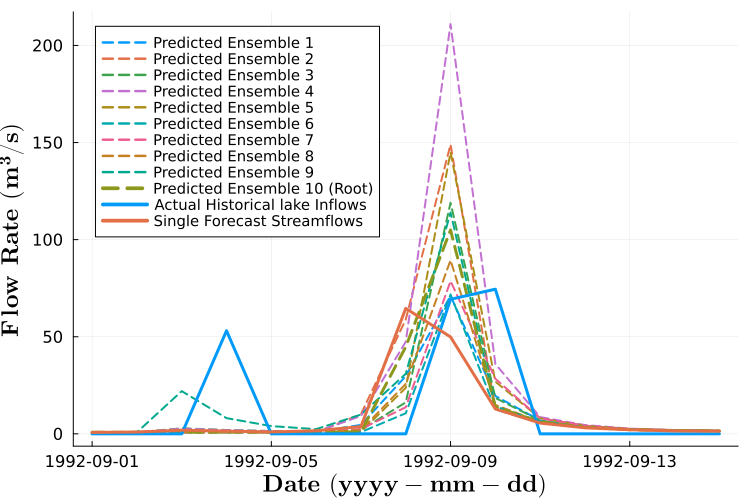

In [314]:
d = DateTime(1992,9,1):Dates.Day(1):DateTime(1992,09,30)
ENF = CSV.read("Ensemble Generation/EF_Flows_Pr.csv", DataFrame)
plotn = plot(d[1:end-15],ENF[!,2][1:end-15], linestyle=:dash, label="Predicted Ensemble 1", dpi=500,legendfont=font(11), lw=2, size=(750,500),tickfontsize=11,labelfontsize=16,legendfontsize=10, legend=:topleft)
plot!(d[1:end-15],ENF[!,3][1:end-15], linestyle=:dash, label="Predicted Ensemble 2", lw=2)
plot!(d[1:end-15],ENF[!,4][1:end-15], linestyle=:dash, label="Predicted Ensemble 3", lw=2)
plot!(d[1:end-15],ENF[!,5][1:end-15], linestyle=:dash, label="Predicted Ensemble 4", lw=2)
plot!(d[1:end-15],ENF[!,6][1:end-15], linestyle=:dash, label="Predicted Ensemble 5", lw=2)
plot!(d[1:end-15],ENF[!,7][1:end-15], linestyle=:dash, label="Predicted Ensemble 6", lw=2)
plot!(d[1:end-15],ENF[!,8][1:end-15], linestyle=:dash, label="Predicted Ensemble 7", lw=2)
plot!(d[1:end-15],ENF[!,9][1:end-15], linestyle=:dash, label="Predicted Ensemble 8", lw=2)
plot!(d[1:end-15],ENF[!,10][1:end-15], linestyle=:dash, label="Predicted Ensemble 9", lw=2)
plot!(d[1:end-15],ENF[!,11][1:end-15], linestyle=:dash, label="Predicted Ensemble 10 (Root)", lw=3)
plot!(d[1:end-15],q_d1992[end-29:end-15], lw=3, color=1, label="Actual Historical lake Inflows")
plot!(d[1:end-15],q_d92_sim[end-6-29:end-6-15], lw=3, color=2 ,label="Single Forecast Streamflows" )
xlabel!(L"\textbf{Date\;\;(yyyy-mm-dd)}")
ylabel!(L"\textbf{Flow\;\;Rate\;\;(m^3/s)}")

In [319]:
#SETUP FOR TB-MPC
M=zeros(720,0)
for i=2:11
    a=[]
    for j=1:30
        append!(a,bell(ENF[!,i][j],12,50))
    end
    M = hcat(M, a)
end
Pr = zeros(0,10)
for row in eachrow(ENF[!,12:21])
   # M = cat(M, values(row),dims = 1)# notice the transpose
    global a = []
    for i= 1:10
        append!(a,round(values(row)[i],digits=4))
    end
    typeof(a) = Float64
    for j=1:24
        Pr = cat(Pr, a',dims = 1)
    end
end

D = zeros(10,10)
for j=1:10
    dum = []
    for t=1:720
        for i=1:10
            if Pr[t,j]/(Pr[t,j]+Pr[t,i])>0.65
                if !(i in dum)
                    append!(dum,i)
                    D[i,j]=t
                end
            end
        end
    end
end
for i=1:10
    D[i,i]= NaN
end

# Tree
# P(10) = 4 , B(10) = Inf
# P(8) = 4 , B(8) = Inf
# P(2) = 1 , B(8) = 577
# P(3) = 9 , B(2) = 433
# P(5) = 6 , B(2) = 385
# P(7) = 4 , B(7) = 385
# P(6) = 4 , B(6) = 361
# P(1) = 9 , B(1) = 169
# P(4) = 9 , B(4) = 169
# P(9) = 9 , B(9) = 1

S1 = M[1:720,9]
S2 = M[1:168,9]
for i = 169:720
    append!(S2,(M[169:i,4][end]))
end
S3 = S1[1:168]
for i = 169:720
    append!(S3,(M[169:i,1][end]))
end
S4 = S3[1:360]
for i = 361:720
    append!(S4,(M[361:i,6][end]))
end
S5 = S3[1:384]
for i = 385:720
    append!(S5,(M[385:i,7][end]))
end
S6 = S4[1:384]
for i = 385:720
    append!(S6,(M[385:i,5][end]))
end
S7 = S1[1:432]
for i = 433:720
    append!(S7,(M[433:i,3][end]))
end
S8 = S2[1:576]
for i = 577:720
    append!(S8,(M[577:i,1][end]))
end
S9 = copy(S3)
S10 = copy(S3)
mat = zeros(720,10)
for i=1:720
    mat[i,1] = S1[i]
    mat[i,2] = S2[i]
    mat[i,3] = S3[i]
    mat[i,4] = S4[i]
    mat[i,5] = S5[i]
    mat[i,6] = S6[i]
    mat[i,7] = S7[i]
    mat[i,8] = S8[i]
    mat[i,9] = S9[i]
    mat[i,10] = S10[i]
end
swapcol!(mat,1,3)
swapcol!(mat,2,4)
swapcol!(mat,4,7)
prob_mat = zeros(720,10)
for i=1:720
    if length(unique(mat[i,1:10]))==1
        prob_mat[i,1:10].=0.1
    else
        B = [[o, count(==(o), mat[i,1:10])] for o in unique(mat[i,1:10])]
        len = length(unique(mat[i,1:10]))
        for k=1:10
            for l=1:len
                # println(l)
                if mat[i,k]==B[l][1]
                    prob_mat[i,k] = B[l][2]/10
                end
            end
        end
    end
end



In [ ]:
#TB-MPC

# initial State at 31 august 1992 (1167 ft)
h_ic = 355.7016-h_ref

# Set Horizon in Hours and initial condition
S = 168
s_ic =vol(h_ic)

# Variable to store results from MPC simulation
global ur6 = []
global ϵ_m6 = []
global xr6 = [s_ic]
global xr_real6 = [s_ic];
global h_real6 = [h_ic]

# global mt = mat[1:end .!= 0, :]
# global prob = prob_mat[1:end .!= 0, :]

w = copy(w_mean_hr[8040:end])
M = 10
Scen = 30
global mt = mat'
global pr = prob_mat'
for i = 8040:8758
    
    if i==8040+169
        M=1
        pr[1,169:end].=1
    end

    u_max = ((sqrt(h_real6[end]/b))*c) + 7.87
    u_min = 0

    if s_ic>s_max
        u_max = ((sqrt(h_real6[end]/b))*c) + 7.87
        u_min = ((sqrt(h_real6[end]/b))*c) + 7.87
    end
    if i>8650
        u_max = w_mean_hr[i]
        u_min = 0
    end
    
    if i>=8760-S
        N = 8760-i
    else
        N = S
    end

    let 

        # create linear system
        A = 1
        B = 3600
        # pr = prob[1:end,m]

        X = cvx.Variable(M, N)
        U = cvx.Variable(M, N - 1)
        b = cvx.Variable(M,1)
        # create cost 
        global cost = 0 

        for k = 1:(N-1)
            for m = 1:M
                cost += pr[m,k]*(cvx.square(cvx.norm(U[m,k]-w[k],2)))
                cost += pr[m,k]*(cvx.norm(b[m],2))
            end
        end

        # initialize cvx problem 
        prob = cvx.minimize(cost)

        # initial condition constraint 
        for m=1:M
            prob.constraints += X[m,1] == s_ic
        end
        

        for k = 1:(N-1)
            # dynamics constraints 
            for m = 1:M
                prob.constraints += (X[m,k+1] == A*X[m,k] - B*U[m,k] + B*mt[m,k]) 
            end
        end


        for k = 1:(N-1)
            for m = 1:M
                prob.constraints += U[m,k] <= u_max
                prob.constraints += U[m,k] >= u_min
            end
        end
        for m = 1:M
            prob.constraints += b[m]>=0
        end
        for k = 1:N
            for m = 1:M
                prob.constraints += X[m,k] <= s_max + b[m]
                prob.constraints += X[m,k] >= s_min 
            end
        end

        cvx.solve!(prob, Mosek.Optimizer; silent_solver = true)
        global X = X.value
        global U = U.value
    end
    
    mt = mt[:, 1:end .!= 1]
    pr = pr[:, 1:end .!= 1]
    append!(ur6,U[1,1])
    popfirst!(w)
    
    dum = s_ic-3600*ur6[end]+3600*q_h1992_2[i+1]
    
    # append!(xr,dum2)
    h_dum = (level(dum)/3.28084)-h_ref
    
    append!(ϵ_m6,max(0,dum-s_max))
    # appending it to actual trajectory of state (volume) for ploting later
    append!(xr_real6,dum)
    append!(h_real6,h_dum)
    # Changing initial condition to actual state after MPC iteration
    s_ic = xr_real6[end]
end

In [ ]:
#ASTB-MPC


# initial State at 31 august 1992 (1167 ft)
h_ic = 355.7016-h_ref

# Set Horizon in Hours and initial condition
S = 168
s_ic =vol(h_ic)

# Variable to store results from MPC simulation
global ur7 = []
global ϵ_m7 = []
global xr7 = [s_ic]
global xr_real7 = [s_ic];
global h_real7 = [h_ic]

# global mt = mat[1:end .!= 0, :]
# global prob = prob_mat[1:end .!= 0, :]

w = copy(w_mean_hr[8040:end])

M = 10
Ms = 100

conv_in = 30
h_dum = h_ic
h_dum2 = h_ic
global mtd = mat'
global mt = mat'
global pr = prob_mat'

for i = 8040:8758
    cost_vec = zeros(Ms)
    control = zeros(Ms)
    dist = zeros(Ms)
    
    if i==8040+169
        M=1
        pr[1,169:end].=1
    end

    u_max = ((sqrt(h_real7[end]/b))*c) + 7.87
    u_min = 0

    if s_ic>s_max
        u_max = ((sqrt(h_real7[end]/b))*c) + 7.87
        u_min = ((sqrt(h_real7[end]/b))*c) + 7.87
    end
    
    if i>8650
        u_max = w_mean_hr[i]
        u_min = 0
    end
    
    if i>=8760-S
        N = 8760-i
    else
        N = S
    end
    
    # conv = max(0,((h_dum-h_dum2)*q_h[i]*q_h[i]))
    conv = max(0,((h_dum-h_dum2)*conv_in*conv_in))
    
    if conv>0
        for s=1:Ms

            mt[1:M,1:end] = max.(0,add_gauss(mtd[1:M,1:end], conv))
           
            let 

                # create linear system
                A = 1
                B = 3600
                # pr = prob[1:end,m]

                X = cvx.Variable(M, N)
                U = cvx.Variable(M, N - 1)
                b = cvx.Variable(M,1)
                # create cost 
                global cost = 0 

                for k = 1:(N-1)
                    for m = 1:M
                        cost += pr[m,k]*(cvx.square(cvx.norm(U[m,k]-w[k],2)))
                        cost += pr[m,k]*(cvx.norm(b[m],2))
                    end
                end

                # initialize cvx problem 
                prob = cvx.minimize(cost)

                # initial condition constraint 
                for m=1:M
                    prob.constraints += X[m,1] == s_ic
                end


                for k = 1:(N-1)
                    # dynamics constraints 
                    for m = 1:M
                        prob.constraints += (X[m,k+1] == A*X[m,k] - B*U[m,k] + B*mt[m,k]) 
                    end
                end


                for k = 1:(N-1)
                    for m = 1:M
                        prob.constraints += U[m,k] <= u_max
                        prob.constraints += U[m,k] >= u_min
                    end
                end
                for m = 1:M
                    prob.constraints += b[m]>=0
                end
                for k = 1:N
                    for m = 1:M
                        prob.constraints += X[m,k] <= s_max + b[m]
                        prob.constraints += X[m,k] >= s_min 
                    end
                end

                cvx.solve!(prob, Mosek.Optimizer; silent_solver = true)
                global X = X.value
                global U = U.value
                cost_vec[s] = prob.optval
            end

            control[s]=U[1]
            dist[s] = mt[1]
        end
        
        index = findmax(cost_vec)[2]
        v = dist[index]
        append!(ur7,control[index])

        mtd = mtd[:, 1:end .!= 1]
        mt = mt[:, 1:end .!= 1]
        pr = pr[:, 1:end .!= 1]

        popfirst!(w)
    else
        mt[1:M,1:end] = mtd[1:M,1:end]
        let 

            # create linear system
            A = 1
            B = 3600
            # pr = prob[1:end,m]

            X = cvx.Variable(M, N)
            U = cvx.Variable(M, N - 1)
            b = cvx.Variable(M,1)
            # create cost 
            global cost = 0 

            for k = 1:(N-1)
                for m = 1:M
                    cost += pr[m,k]*(cvx.square(cvx.norm(U[m,k]-w[k],2)))
                    cost += pr[m,k]*(cvx.norm(b[m],2))
                end
            end

            # initialize cvx problem 
            prob = cvx.minimize(cost)

            # initial condition constraint 
            for m=1:M
                prob.constraints += X[m,1] == s_ic
            end


            for k = 1:(N-1)
                # dynamics constraints 
                for m = 1:M
                    prob.constraints += (X[m,k+1] == A*X[m,k] - B*U[m,k] + B*mt[m,k]) 
                end
            end


            for k = 1:(N-1)
                for m = 1:M
                    prob.constraints += U[m,k] <= u_max
                    prob.constraints += U[m,k] >= u_min
                end
            end
            for m = 1:M
                prob.constraints += b[m]>=0
            end
            for k = 1:N
                for m = 1:M
                    prob.constraints += X[m,k] <= s_max + b[m]
                    prob.constraints += X[m,k] >= s_min 
                end
            end

            cvx.solve!(prob, Mosek.Optimizer; silent_solver = true)
            global X = X.value
            global U = U.value
        end
        v = mt[1,]
        mtd = mtd[:, 1:end .!= 1]
        mt = mt[:, 1:end .!= 1]
        pr = pr[:, 1:end .!= 1]

        append!(ur7,U[1,1])
        popfirst!(w)
    end
        

    # Apply actual disturbance with control input generated using simulated disturbance/inflow
    # # for 2018 Scenario
    # dum = s_ic-3600*ur[end]+3600*q_h2018[i+1]
    # # for 2015 Scenario
    # dum = s_ic-3600*ur[end]+3600*q_h2015[i+1]
    # # for 2020 Scenario
    # dum = s_ic-3600*ur[end]+3600*q_h2020[i+1]
    # for 1992 Scenario
    dum = s_ic-3600*ur7[end]+3600*q_h1992_2[i+1]
    dum2 = s_ic-3600*ur7[end]+3600*v
    # append!(xr,dum2)
    h_dum = (level(dum)/3.28084)-h_ref
    h_dum2 = (level(dum2)/3.28084)-h_ref
    
    append!(ϵ_m7,max(0,dum-s_max))
    # appending it to actual trajectory of state (volume) for ploting later
    append!(xr_real7,dum)
    append!(h_real7,h_dum)
    # Changing initial condition to actual state after MPC iteration
    s_ic = xr_real7[end]
    
end

In [ ]:
# PF-MPC Simulation

# # initial height at for 2014-15
# h_ic = 353.47656-h_ref

# # initial height at for 2017-18
# h_ic = 354.26904-h_ref

# # # initial height at for 2019-20
# h_ic = 354.08616-h_ref

# # # initial height at for 1991-92 (1161)
# h_ic = 353.8728-h_ref

# initial State at 31 august 1992 (1167 ft)
h_ic = 355.7016-h_ref

# Set Horizon in Hours and initial condition
S = 168
s_ic =vol(h_ic)

# Variable to store results from MPC simulation
global ur5 = []
global ϵ_m5 = []
global xr5 = []
global xr_real5 = [s_ic];
global h_real5 = [h_ic]

w = copy(w_mean_hr[8040:8760])

# q = copy(q_h2018)
# q = copy(q_h2015)
# q = copy(q_h[8040:8760])

# # For Hydrologic-MPC for 1992 Scenario
# q = copy(q_d92_sim)

q = copy(q_h1992_2[8040:8760])

# # # For Fbprophet based Scenario MPC for 1992 Scenario
# q = copy(qh_prophet[8040:8760])


# day = 334
for i = 8040:8758
    # cost_vec = zeros(M)
    # control = zeros(M)
    # for m=1:M
    # if mod(i,24)==0
    #     day = day+1
    #     q = []
    #     for j=day:day+6
    #         append!(q,bell(q_d92_sim[j],12))
    #     end
    # end

    if (i>7000 && i<8400)
        u_max = ((sqrt(h_real5[end]/b))*c) + 7.87
        u_min = 0
    else
        u_max = (sqrt(h_real5[end]/b))*c
        u_min = 0
    end

    if s_ic>s_max
        u_max = ((sqrt(h_real5[end]/b))*c) + 7.87
        u_min = ((sqrt(h_real5[end]/b))*c) + 7.87
    end

    if i>8650
        u_max = w_mean_hr[i]
        u_min = 0
    end

    let 

        # create linear system
        A = 1
        B = 3600

        # time steps 

        if i>=8760-S
            N = 8760-i
        else
            N = S
        end

        # create cvx variables
        X = cvx.Variable(1, N)
        U = cvx.Variable(1, N - 1)
        b = cvx.Variable()
        # create cost 
        global cost = 0 
        for k = 1:(N-1)
            cost += cvx.square(cvx.norm(U[k]-w[k],2))
            cost += 1000*cvx.norm(b,2)
        end

        # initialize cvx problem 
        prob = cvx.minimize(cost)

        # initial condition constraint 
        prob.constraints += X[1] == s_ic

        for k = 1:(N-1)
            # dynamics constraints 
            prob.constraints += (X[k+1] == A*X[k] - B*U[k] + B*q[k]) 
        end


        for k = 1:(N-1)
            prob.constraints += U[k] <= u_max
            prob.constraints += U[k] >= u_min
        end

        prob.constraints += b>=0
        for k = 1:N
            prob.constraints += X[k] <= s_max + b
            prob.constraints += X[k] >= s_min 
        end

        cvx.solve!(prob, Mosek.Optimizer; silent_solver = true)
        global X = X.value
        global U = U.value
        # cost_vec[m] = prob.optval
        # append!(ϵ_m2,b.value)
    end

    if i<8758
        x_dum = vec(X)
        u_dum = vec(U);

        append!(xr5,x_dum[2])
        append!(ur5,u_dum[1])

        popfirst!(q)
        popfirst!(w)
    else
        x_dum = vec(X)
        append!(xr5,x_dum)
        append!(ur5,U)
    end

    # Apply actual disturbance with control input generated using simulated disturbance/inflow
    # # for 2018 Scenario
    # dum = s_ic-3600*ur[end]+3600*q_h2018[i+1]
    # # for 2015 Scenario
    # dum = s_ic-3600*ur[end]+3600*q_h2015[i+1]
    # # for 2020 Scenario
    # dum = s_ic-3600*ur[end]+3600*q_h2020[i+1]
    # for 1992 Scenario
    dum = s_ic-3600*ur5[end]+3600*q_h1992_2[i+1]
    h_dum = (level(dum)/3.28084)-h_ref
    
    # appending it to actual trajectory of state (volume) for ploting later
    append!(xr_real5,dum)
    append!(h_real5,h_dum)
    append!(ϵ_m5,max(0,dum-s_max))
    # Changing initial condition to actual state after MPC iteration
    s_ic = xr_real5[end]
end

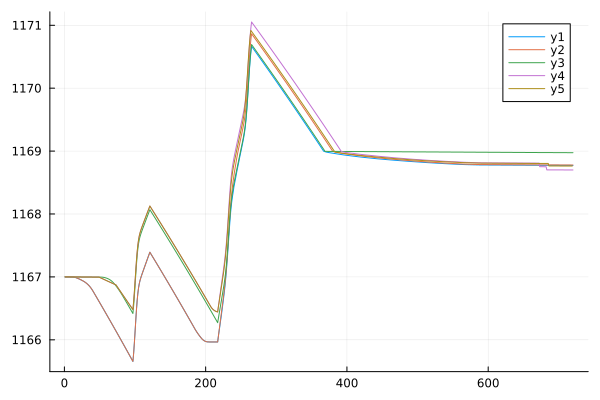

In [406]:
plot(level.(xr_real7))
plot!(level.(xr_real6))
plot!(level.(xr_real5))
plot!(level.(xr_real2))
plot!(level.(xr_real0))
